# Visualize ACT Training Data

This notebook helps you visualize the training data for ACT policy:
- Individual observation-action pairs
- Temporal context sequences (multiple past observations)
- Action chunks (future action sequences)
- Dataset statistics

## Setup

First, specify your dataset directory path below.


In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Add project root to path
project_root = Path(os.getcwd())
sys.path.append(str(project_root))

# Import dataset classes
from train.dataset import BimanualDataset, TensorBimanualObs, TensorBimanualAction
from policy.act.dataset import TemporalBimanualDataset

print("✓ Imports successful")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home_shared/grail_andre/miniforge3/envs/act_training/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


✓ Imports successful


## Load Dataset

Specify your dataset directory path here. The dataset should contain:
- `observations.npy`
- `actions.npy`
- `metadata.txt`
- `rollout_length.npy`


In [4]:
# ===== CONFIGURATION =====
# Update this path to point to your dataset directory
DATASET_DIR = "bc-train-data-test"  # Change this to your dataset path
TEMPORAL_CONTEXT = 3  # Number of past observations (should match your config)
CHUNK_SIZE = 30       # Number of future actions (should match your config)

# ===== Load Datasets =====
dataset_path = Path(DATASET_DIR)
if not dataset_path.exists():
    raise FileNotFoundError(f"Dataset not found at: {dataset_path}")

print(f"Loading dataset from: {dataset_path}")
base_dataset = BimanualDataset(dataset_path)
print(f"✓ Base dataset loaded: {len(base_dataset)} samples")

# Load temporal dataset (for ACT training)
temporal_dataset = TemporalBimanualDataset(
    base_dataset=base_dataset,
    temporal_context=TEMPORAL_CONTEXT,
    chunk_size=CHUNK_SIZE,
    pad_mode='repeat'
)
print(f"✓ Temporal dataset loaded: {len(temporal_dataset)} valid samples")

# Print dataset metadata
metadata = base_dataset.metadata
print(f"\nDataset Metadata:")
print(f"  - Total samples: {metadata.sample_count}")
print(f"  - Rollouts: {metadata.rollout_count}")
print(f"  - Camera size: {metadata.camera_height}x{metadata.camera_width}")
print(f"  - Skip frames: {metadata.skip_frames}")
print(f"  - Max steps per rollout: {metadata.max_steps_per_rollout}")
print(f"  - Rollout lengths: {metadata.rollout_lengths[:5]}..." if len(metadata.rollout_lengths) > 5 else f"  - Rollout lengths: {metadata.rollout_lengths}")


Loading dataset from: bc-train-data-test
✓ Base dataset loaded: 10000 samples
✓ Temporal dataset loaded: 7941 valid samples

Dataset Metadata:
  - Total samples: 10000
  - Rollouts: 71
  - Camera size: 128x128
  - Skip frames: 2
  - Max steps per rollout: 600
  - Rollout lengths: [np.uint16(125), np.uint16(146), np.uint16(142), np.uint16(142), np.uint16(122)]...


/home_shared/grail_andre/code/bimaminobolonana/train/dataset.py:137: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  self._observation_array = torch.from_numpy(observation_array)


## Visualization Functions

Helper functions to visualize observations and actions.


In [5]:
def visualize_observation(obs: TensorBimanualObs, title: str = "Observation"):
    """
    Visualize a single observation (both camera views).

    Args:
        obs: TensorBimanualObs with visual shape (1, 2, H, W, 3)
        title: Title for the plot
    """
    # Extract images: shape (1, 2, H, W, 3) -> (2, H, W, 3)
    visual = obs.visual[0].cpu().numpy()  # Remove batch dimension
    left_img = visual[0]  # Left wrist camera
    right_img = visual[1]  # Right wrist camera

    # Ensure values are in [0, 1] range
    left_img = np.clip(left_img, 0, 1)
    right_img = np.clip(right_img, 0, 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(title, fontsize=14, fontweight='bold')

    axes[0].imshow(left_img)
    axes[0].set_title("Left Wrist Camera", fontsize=12)
    axes[0].axis('off')

    axes[1].imshow(right_img)
    axes[1].set_title("Right Wrist Camera", fontsize=12)
    axes[1].axis('off')

    plt.tight_layout()
    return fig

def visualize_action(action: TensorBimanualAction, title: str = "Action"):
    """
    Visualize action values as a bar chart.

    Args:
        action: TensorBimanualAction with shape (1, 14)
        title: Title for the plot
    """
    action_array = action.array[0].cpu().numpy()  # Remove batch dimension

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.bar(range(len(action_array)), action_array)
    ax.set_xlabel("Action Dimension", fontsize=11)
    ax.set_ylabel("Action Value", fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(len(action_array)))
    ax.set_xticklabels([f"A{i}" for i in range(len(action_array))])

    plt.tight_layout()
    return fig

def visualize_observation_action_pair(obs: TensorBimanualObs, action: TensorBimanualAction,
                                      sample_idx: int = None):
    """
    Visualize a single observation-action pair.

    Args:
        obs: TensorBimanualObs
        action: TensorBimanualAction
        sample_idx: Optional sample index for title
    """
    title = f"Sample {sample_idx}" if sample_idx is not None else "Sample"

    fig = plt.figure(figsize=(16, 6))
    gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 1])

    # Extract images
    visual = obs.visual[0].cpu().numpy()
    left_img = np.clip(visual[0], 0, 1)
    right_img = np.clip(visual[1], 0, 1)

    # Left camera
    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(left_img)
    ax1.set_title("Left Wrist Camera", fontsize=11)
    ax1.axis('off')

    # Right camera
    ax2 = fig.add_subplot(gs[1])
    ax2.imshow(right_img)
    ax2.set_title("Right Wrist Camera", fontsize=11)
    ax2.axis('off')

    # Action
    ax3 = fig.add_subplot(gs[2])
    action_array = action.array[0].cpu().numpy()
    ax3.bar(range(len(action_array)), action_array, color='steelblue')
    ax3.set_xlabel("Action Dim", fontsize=10)
    ax3.set_ylabel("Value", fontsize=10)
    ax3.set_title("Action", fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(range(0, len(action_array), 2))

    fig.suptitle(title, fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

print("✓ Visualization functions defined")


✓ Visualization functions defined


## 1. Visualize Individual Observation-Action Pairs

Visualize single samples from the base dataset to see the observation-action pairing.


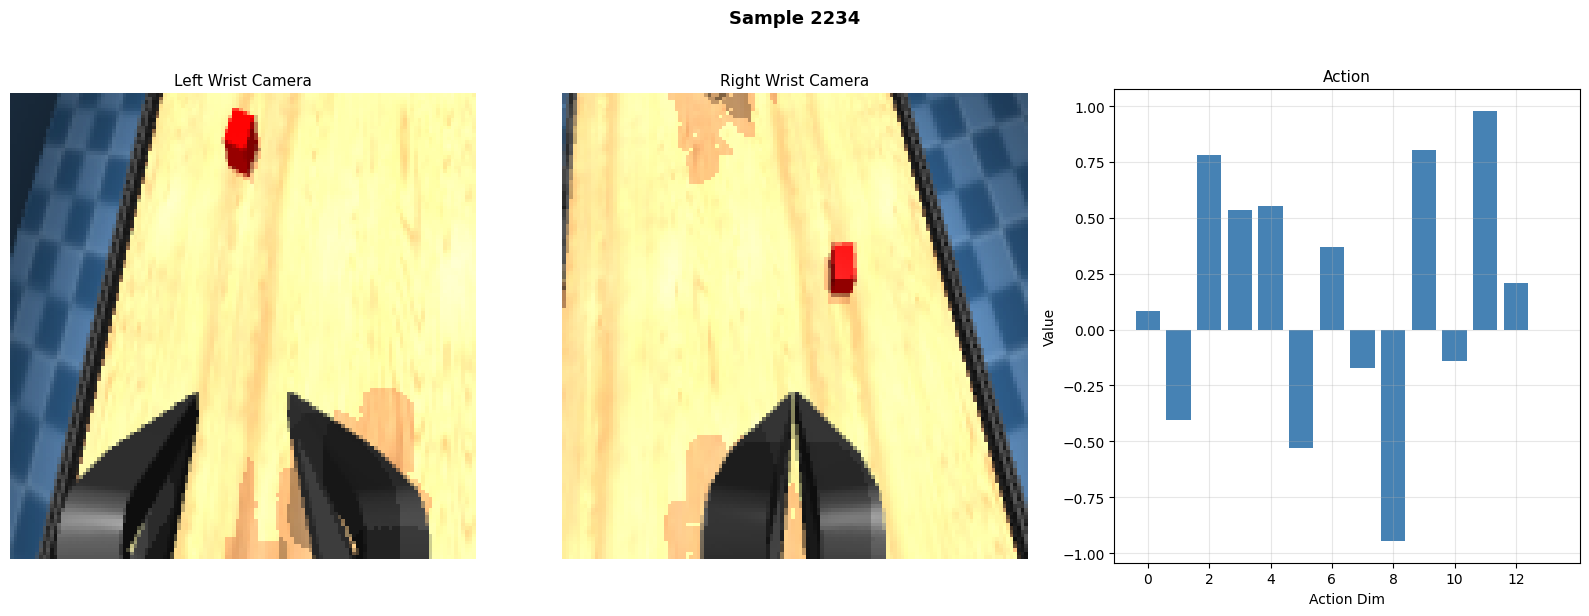


Sample 2234:
  Observation shape: torch.Size([1, 2, 128, 128, 3])
  Action shape: torch.Size([1, 14])
  Action range: [-0.947, 0.979]



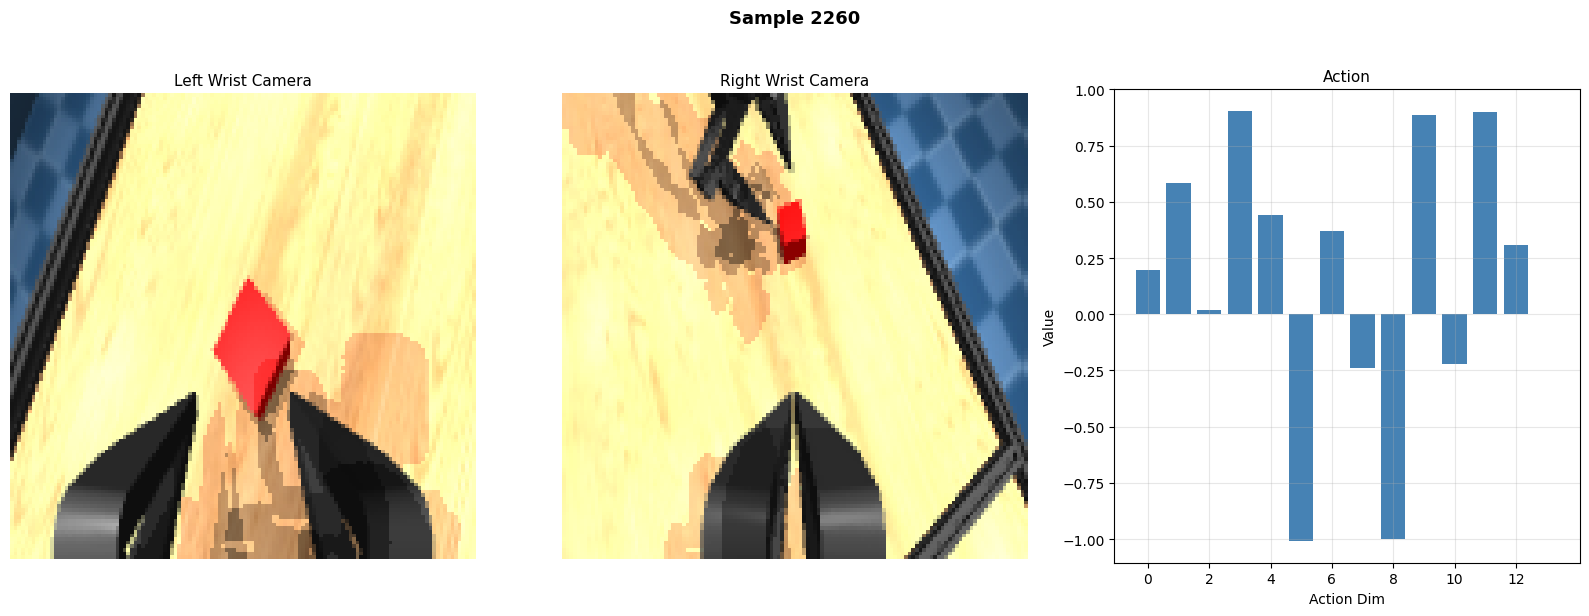


Sample 2260:
  Observation shape: torch.Size([1, 2, 128, 128, 3])
  Action shape: torch.Size([1, 14])
  Action range: [-1.010, 0.905]



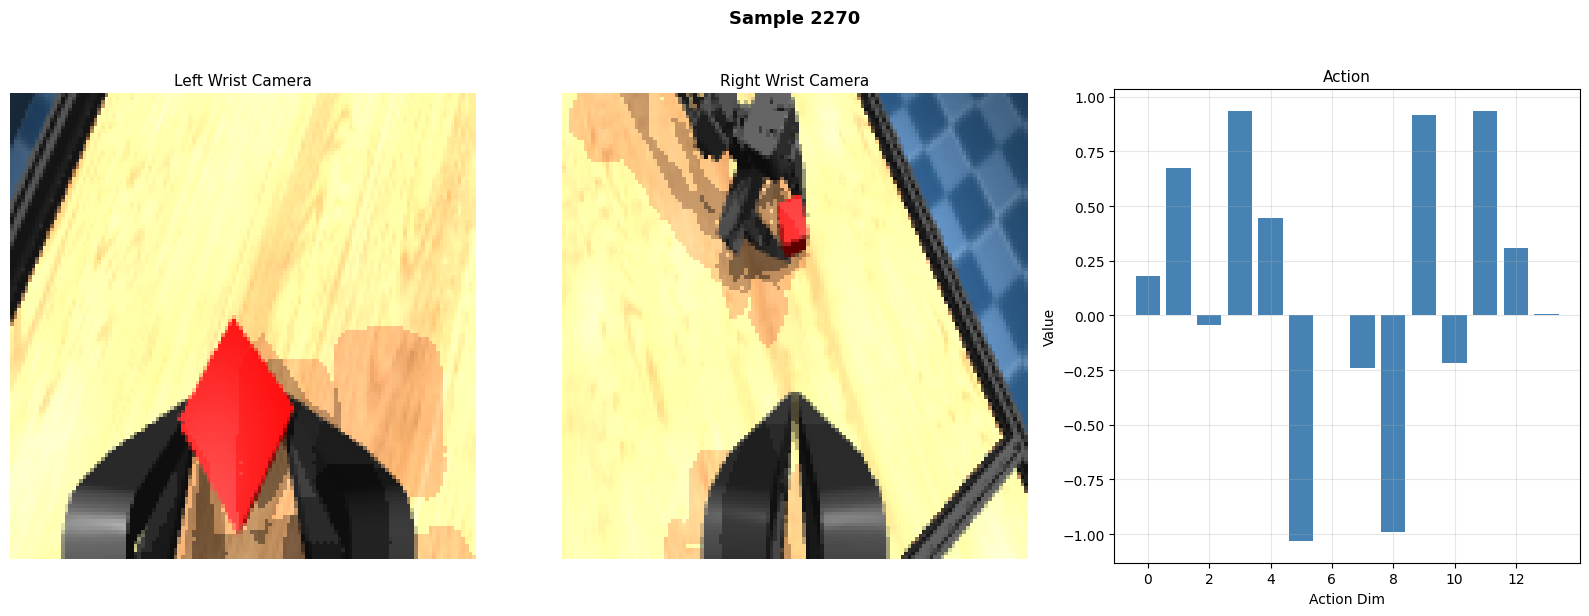


Sample 2270:
  Observation shape: torch.Size([1, 2, 128, 128, 3])
  Action shape: torch.Size([1, 14])
  Action range: [-1.033, 0.936]



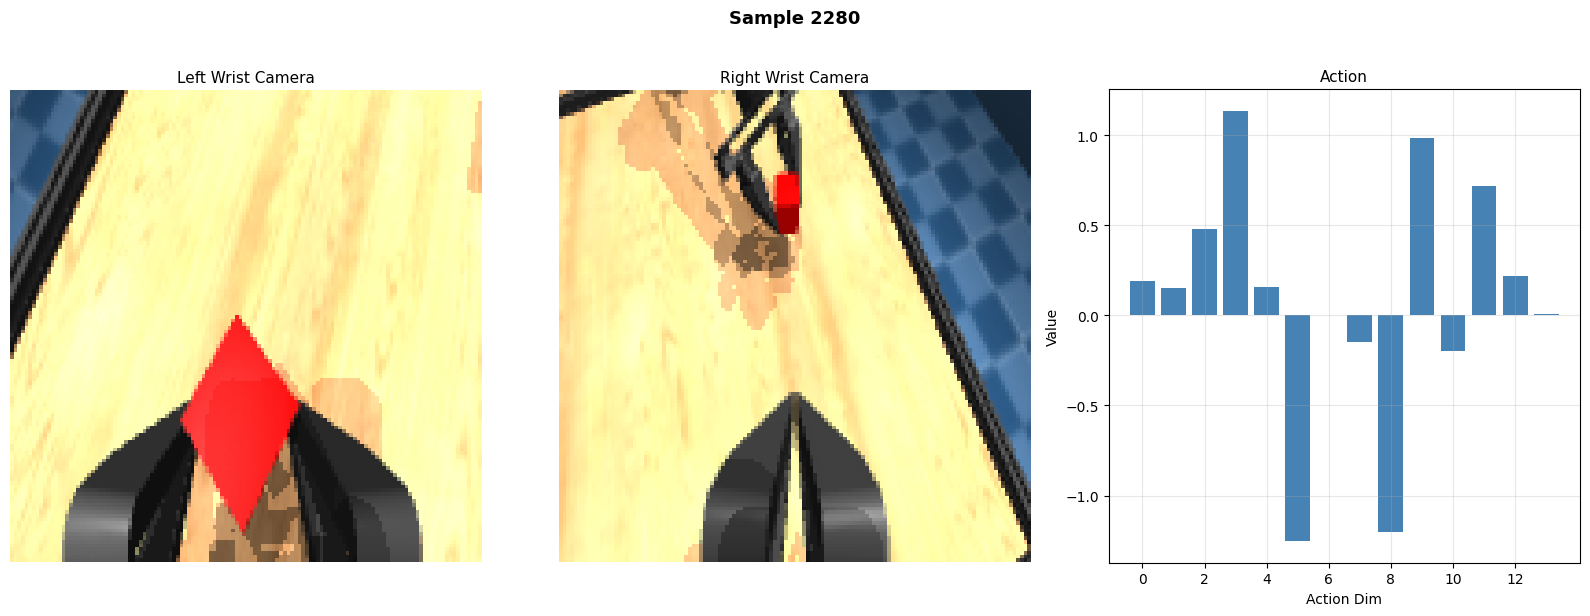


Sample 2280:
  Observation shape: torch.Size([1, 2, 128, 128, 3])
  Action shape: torch.Size([1, 14])
  Action range: [-1.254, 1.137]



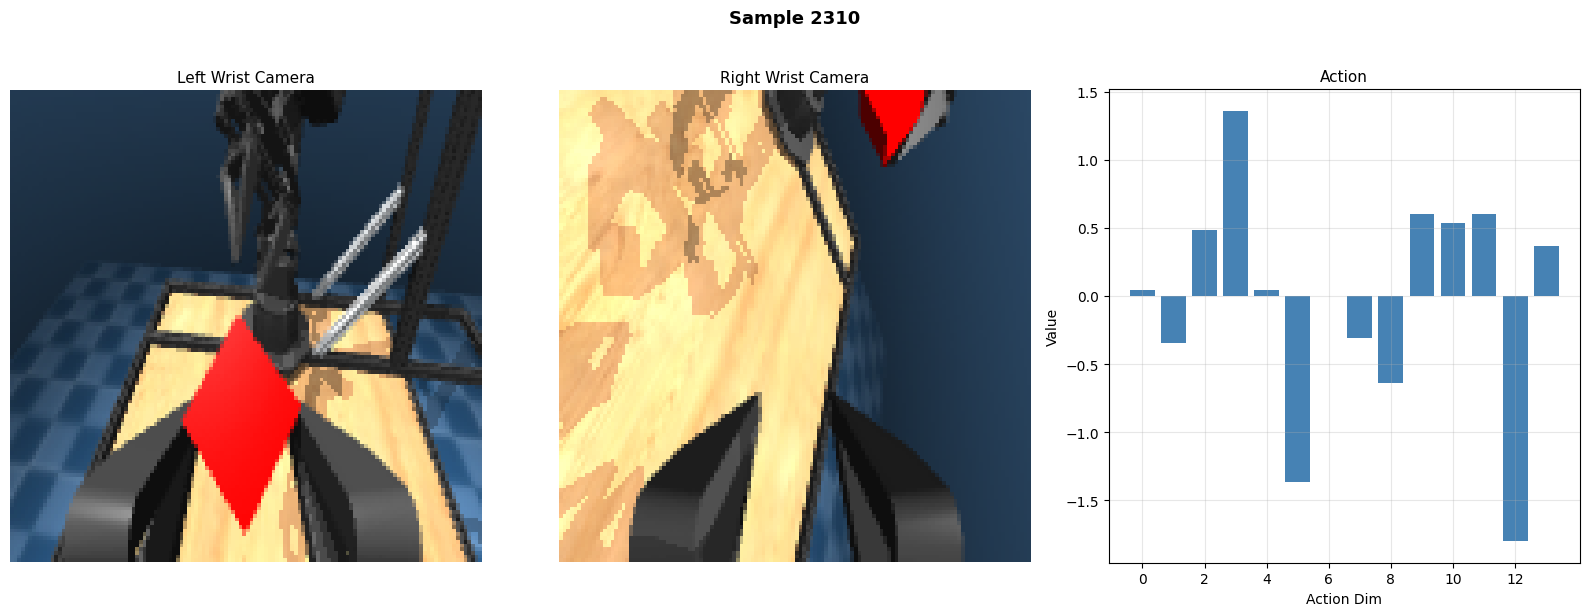


Sample 2310:
  Observation shape: torch.Size([1, 2, 128, 128, 3])
  Action shape: torch.Size([1, 14])
  Action range: [-1.801, 1.359]



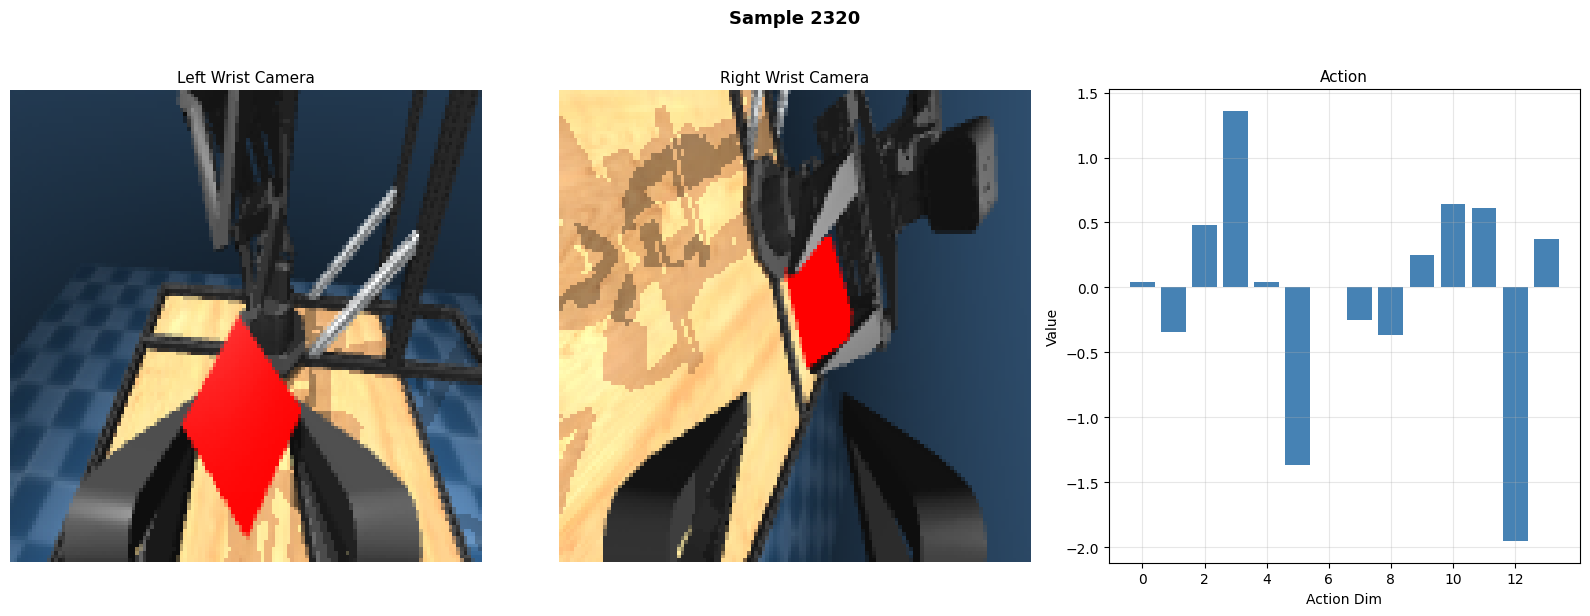


Sample 2320:
  Observation shape: torch.Size([1, 2, 128, 128, 3])
  Action shape: torch.Size([1, 14])
  Action range: [-1.952, 1.359]



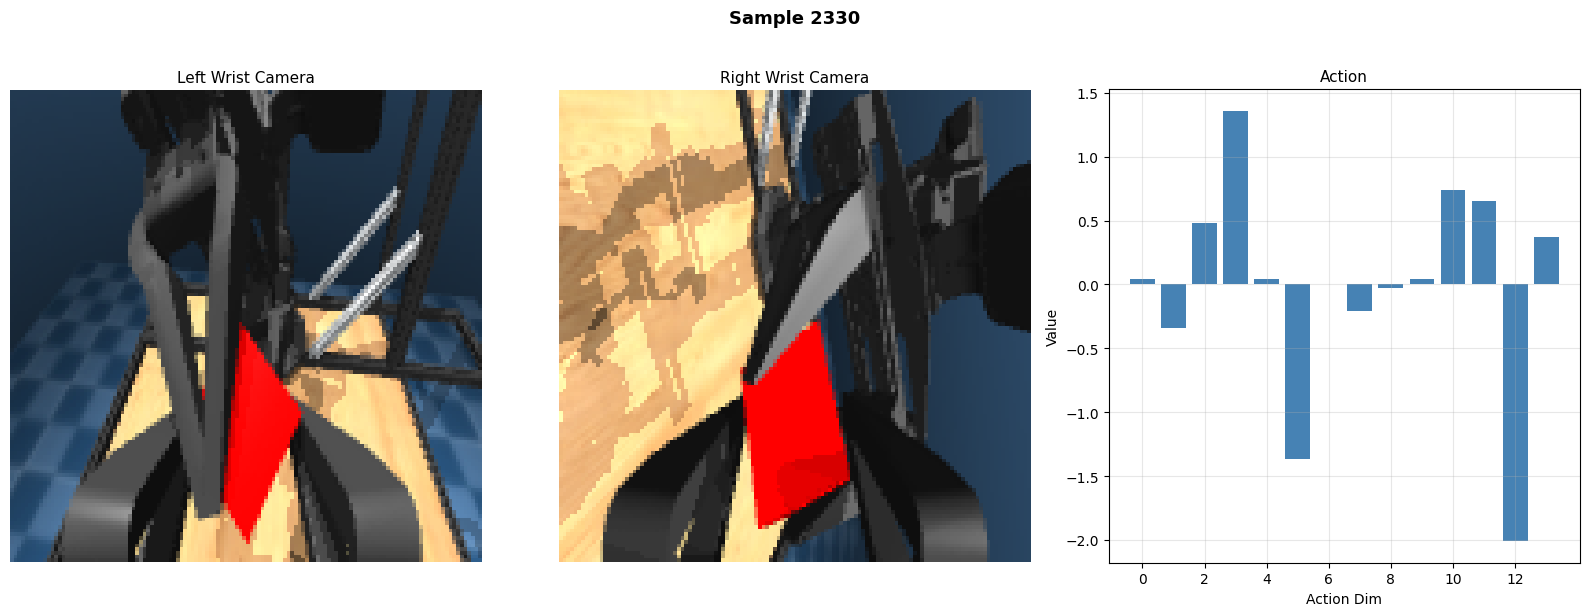


Sample 2330:
  Observation shape: torch.Size([1, 2, 128, 128, 3])
  Action shape: torch.Size([1, 14])
  Action range: [-2.010, 1.359]



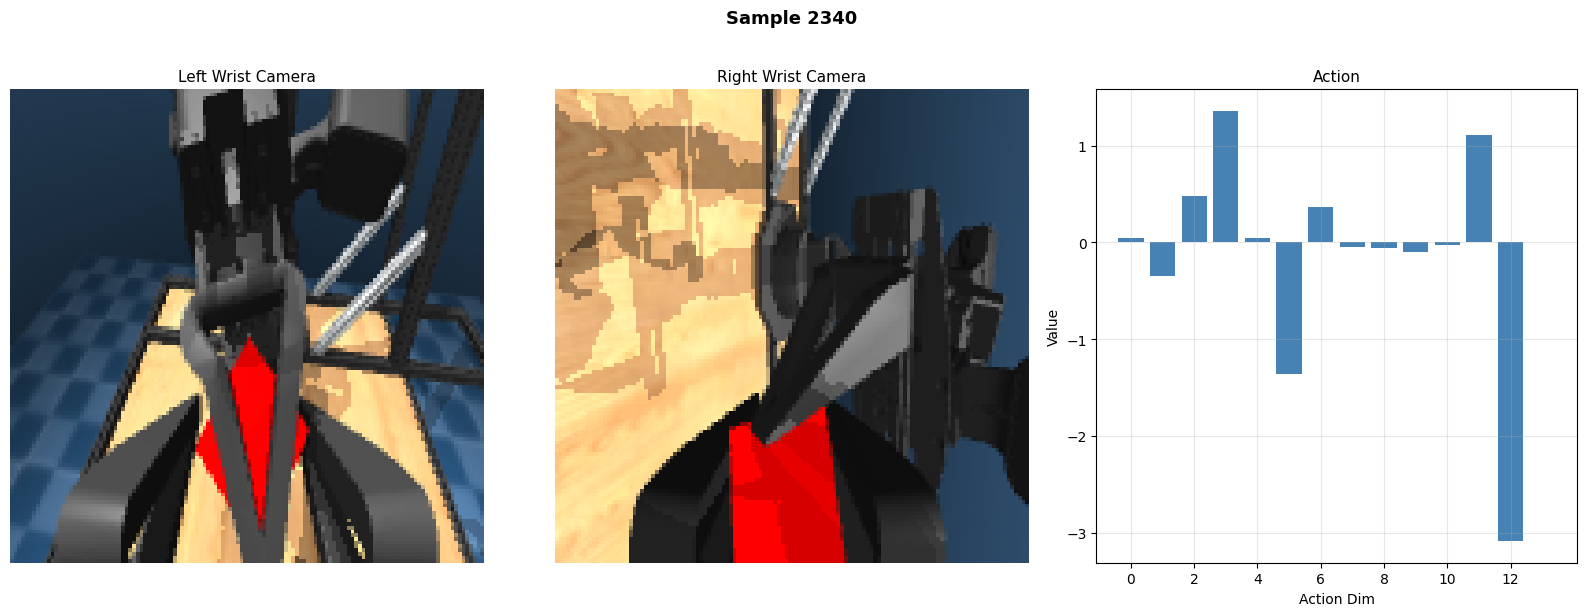


Sample 2340:
  Observation shape: torch.Size([1, 2, 128, 128, 3])
  Action shape: torch.Size([1, 14])
  Action range: [-3.088, 1.359]



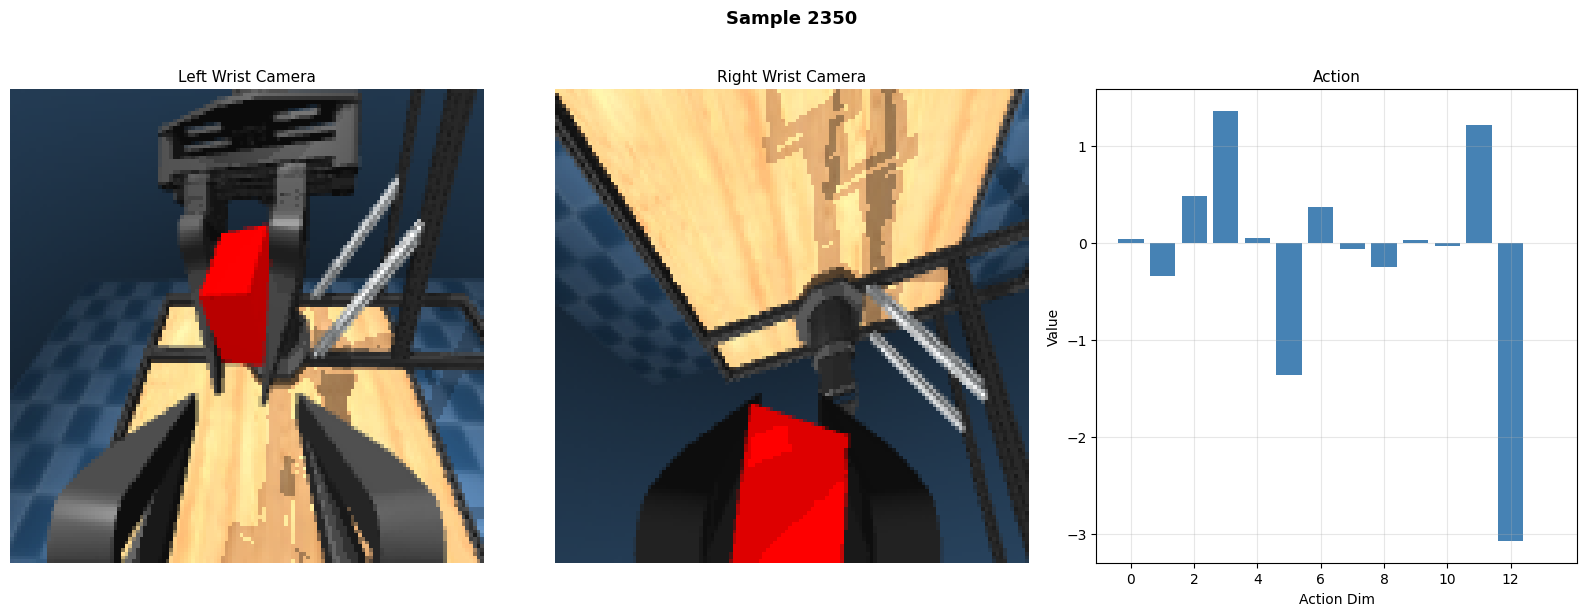


Sample 2350:
  Observation shape: torch.Size([1, 2, 128, 128, 3])
  Action shape: torch.Size([1, 14])
  Action range: [-3.075, 1.359]



In [18]:
# Visualize a few random samples
num_samples_to_show = 3
sample_indices = np.random.choice(len(base_dataset), num_samples_to_show, replace=False)

for idx in [2234,2260,2270,2280,2310,2320,2330,2340,2350]:
    obs, action = base_dataset[idx]
    fig = visualize_observation_action_pair(obs, action, sample_idx=idx)
    plt.show()
    print(f"\nSample {idx}:")
    print(f"  Observation shape: {obs.visual.shape}")
    print(f"  Action shape: {action.array.shape}")
    print(f"  Action range: [{action.array.min():.3f}, {action.array.max():.3f}]")
    print()


/tmp/ipykernel_2001662/1778293644.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


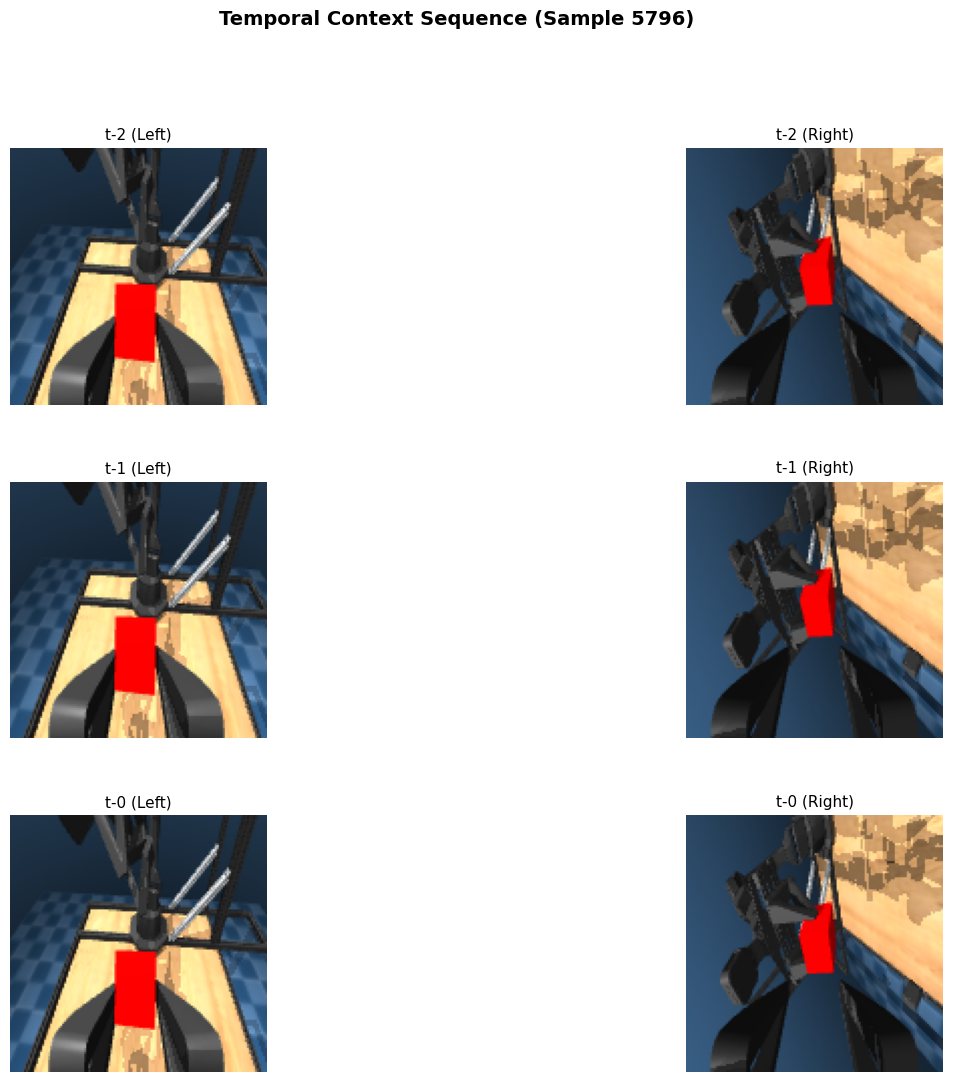


Temporal Sample 5796:
  Observation sequence shape: torch.Size([3, 2, 128, 128, 3])
  Action chunk shape: torch.Size([30, 14])



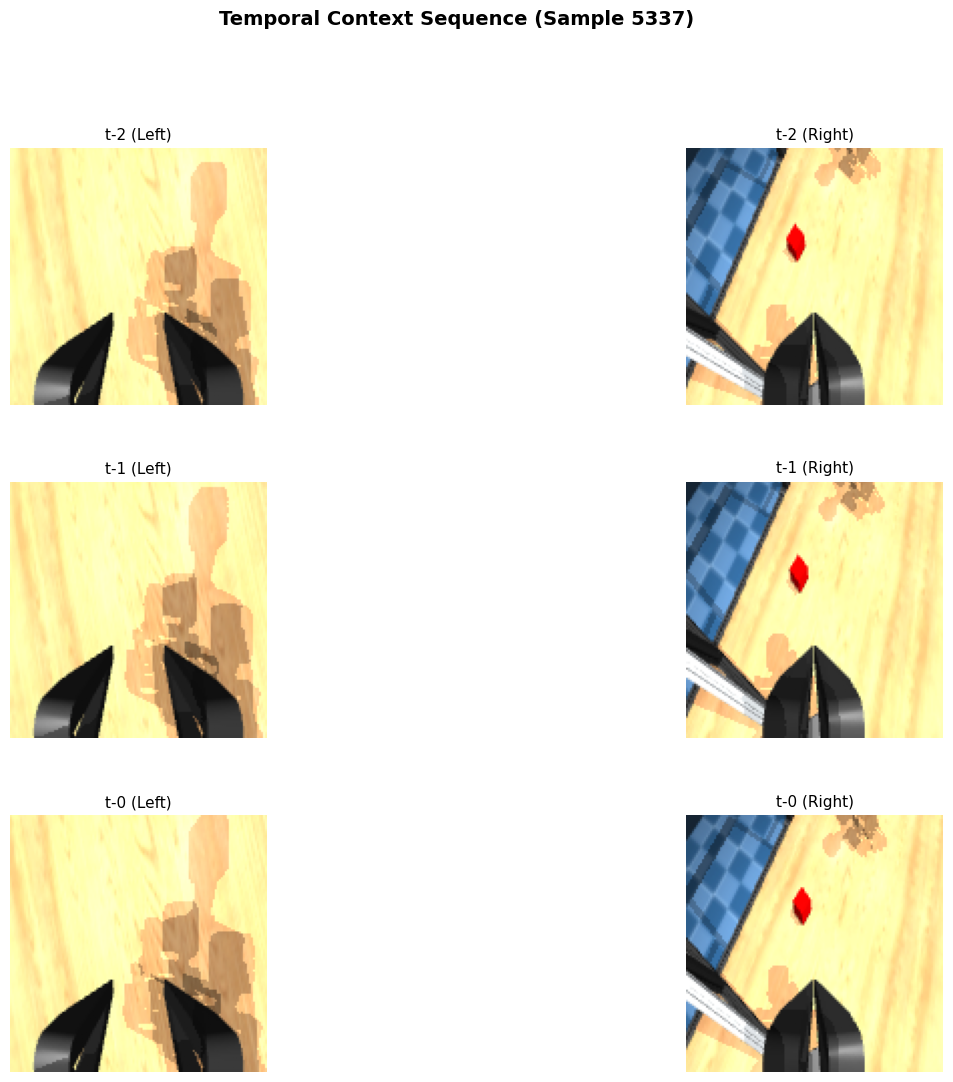


Temporal Sample 5337:
  Observation sequence shape: torch.Size([3, 2, 128, 128, 3])
  Action chunk shape: torch.Size([30, 14])



In [8]:
def visualize_temporal_context(obs_sequence: TensorBimanualObs, sample_idx: int = None):
    """
    Visualize temporal context: sequence of past observations.

    Args:
        obs_sequence: TensorBimanualObs with visual shape (temporal_context, 2, H, W, 3)
        sample_idx: Optional sample index for title
    """
    # Extract temporal sequence: shape (temporal_context, 2, H, W, 3)
    visual = obs_sequence.visual.cpu().numpy()
    temporal_context = visual.shape[0]

    fig = plt.figure(figsize=(16, 4 * temporal_context))
    gs = GridSpec(temporal_context, 2, figure=fig, hspace=0.3, wspace=0.2)

    title = f"Temporal Context Sequence (Sample {sample_idx})" if sample_idx is not None else "Temporal Context Sequence"
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.995)

    for t in range(temporal_context):
        left_img = np.clip(visual[t, 0], 0, 1)
        right_img = np.clip(visual[t, 1], 0, 1)

        # Left camera
        ax1 = fig.add_subplot(gs[t, 0])
        ax1.imshow(left_img)
        ax1.set_title(f"t-{temporal_context-1-t} (Left)", fontsize=11)
        ax1.axis('off')

        # Right camera
        ax2 = fig.add_subplot(gs[t, 1])
        ax2.imshow(right_img)
        ax2.set_title(f"t-{temporal_context-1-t} (Right)", fontsize=11)
        ax2.axis('off')

    plt.tight_layout()
    return fig

# Visualize a few temporal sequences
num_temporal_samples = 2
temporal_indices = np.random.choice(len(temporal_dataset), num_temporal_samples, replace=False)

for idx in temporal_indices:
    obs_sequence, action_chunk = temporal_dataset[idx]
    fig = visualize_temporal_context(obs_sequence, sample_idx=idx)
    plt.show()
    print(f"\nTemporal Sample {idx}:")
    print(f"  Observation sequence shape: {obs_sequence.visual.shape}")
    print(f"  Action chunk shape: {action_chunk.array.shape}")
    print()


## 3. Visualize Action Chunk

Visualize the action chunk (sequence of future actions) that the model predicts.


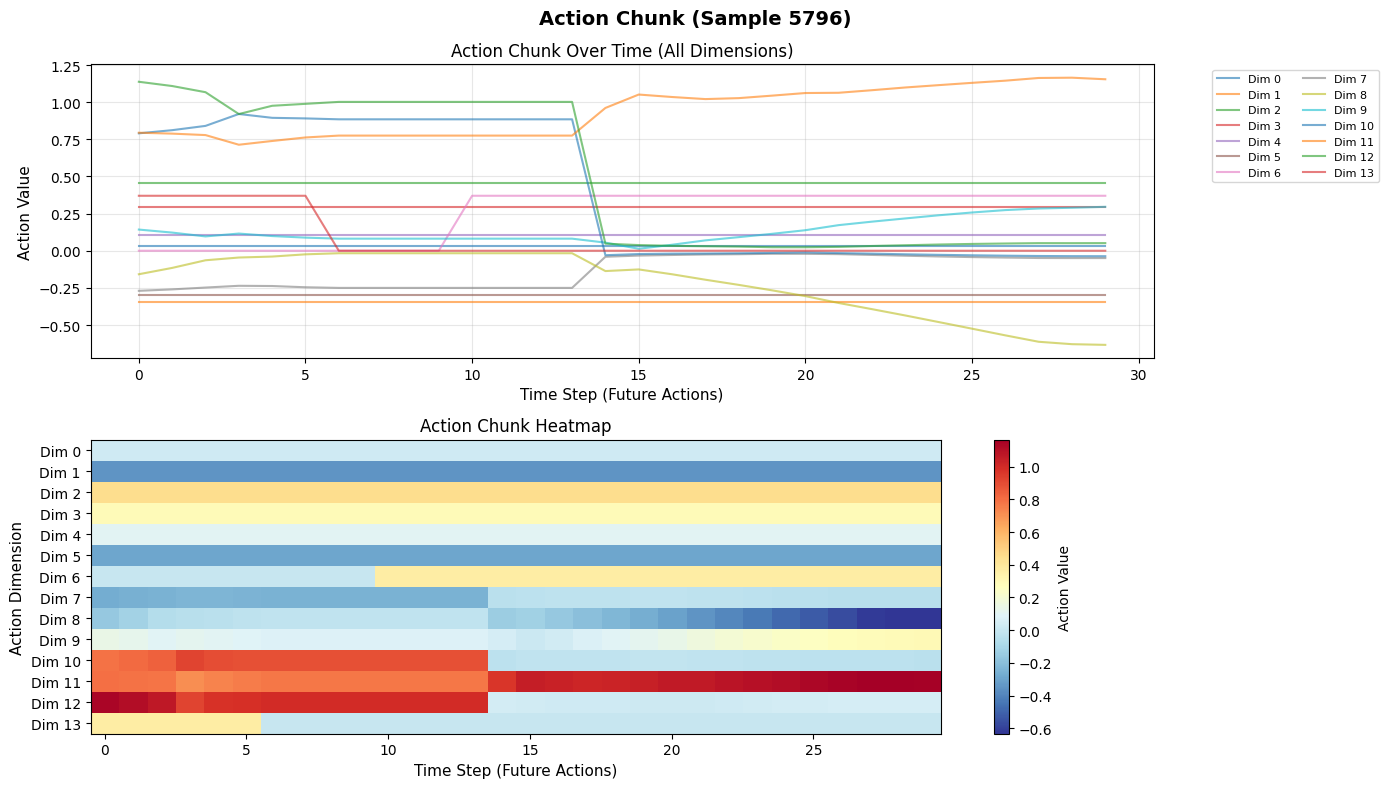

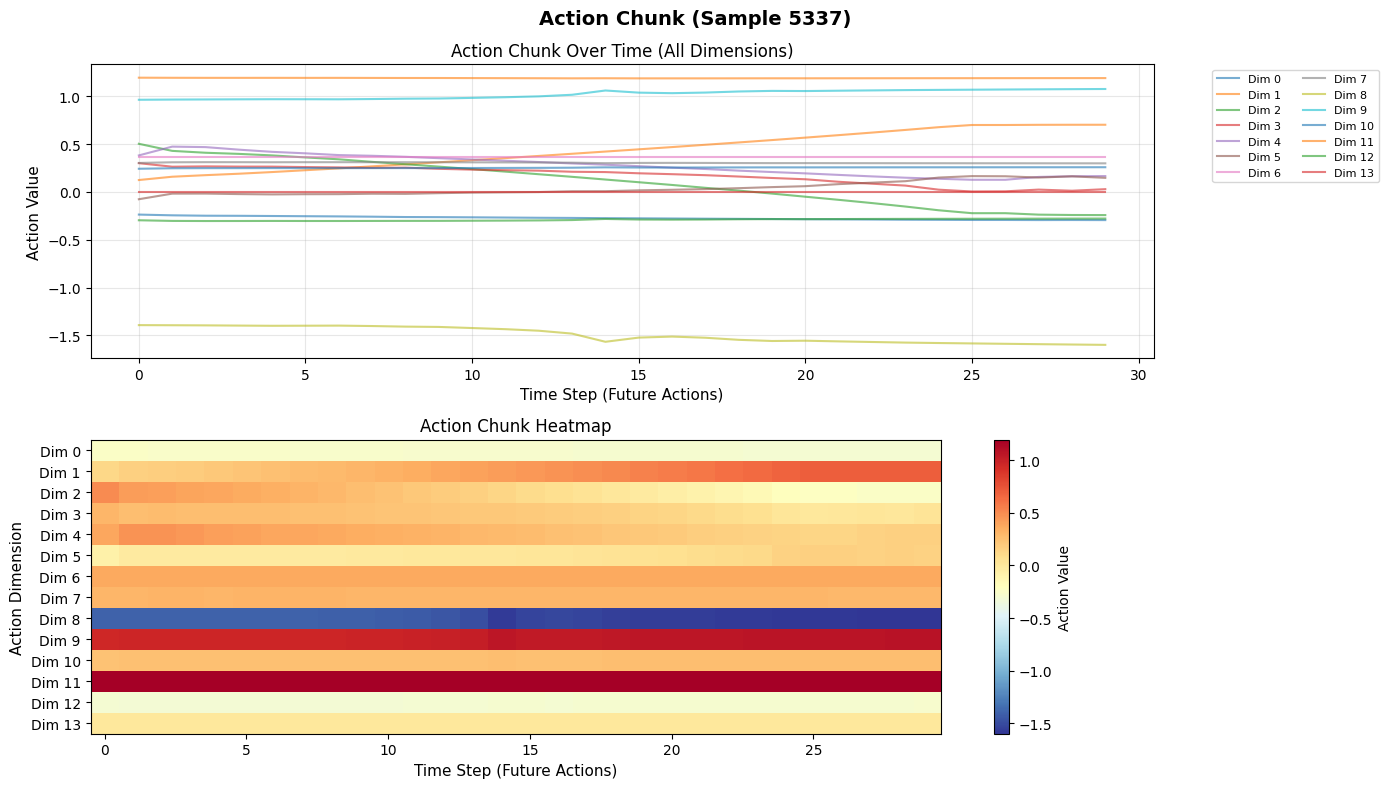

In [ ]:
def visualize_action_chunk(action_chunk: TensorBimanualAction, sample_idx: int = None):
    """
    Visualize action chunk: sequence of future actions.

    Args:
        action_chunk: TensorBimanualAction with shape (chunk_size, 14)
        sample_idx: Optional sample index for title
    """
    action_array = action_chunk.array.cpu().numpy()  # Shape: (chunk_size, 14)
    chunk_size = action_array.shape[0]

    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    title = f"Action Chunk (Sample {sample_idx})" if sample_idx is not None else "Action Chunk"
    fig.suptitle(title, fontsize=14, fontweight='bold')

    # Plot 1: All actions over time (one line per action dimension)
    ax1 = axes[0]
    for dim in range(action_array.shape[1]):
        ax1.plot(range(chunk_size), action_array[:, dim], alpha=0.6, label=f"Dim {dim}")
    ax1.set_xlabel("Time Step (Future Actions)", fontsize=11)
    ax1.set_ylabel("Action Value", fontsize=11)
    ax1.set_title("Action Chunk Over Time (All Dimensions)", fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)

    # Plot 2: Heatmap of actions
    ax2 = axes[1]
    im = ax2.imshow(action_array.T, aspect='auto', cmap='RdYlBu_r', interpolation='nearest')
    ax2.set_xlabel("Time Step (Future Actions)", fontsize=11)
    ax2.set_ylabel("Action Dimension", fontsize=11)
    ax2.set_title("Action Chunk Heatmap", fontsize=12)
    ax2.set_yticks(range(action_array.shape[1]))
    ax2.set_yticklabels([f"Dim {i}" for i in range(action_array.shape[1])])
    plt.colorbar(im, ax=ax2, label="Action Value")

    plt.tight_layout()
    return fig

# Visualize action chunks for the same samples
for idx in temporal_indices:
    obs_sequence, action_chunk = temporal_dataset[idx]
    fig = visualize_action_chunk(action_chunk, sample_idx=idx)
    plt.show()
    print()


## 4. Visualize Complete ACT Training Sample

Visualize both the temporal context (input) and action chunk (target) together.


/tmp/ipykernel_2001662/3285485810.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


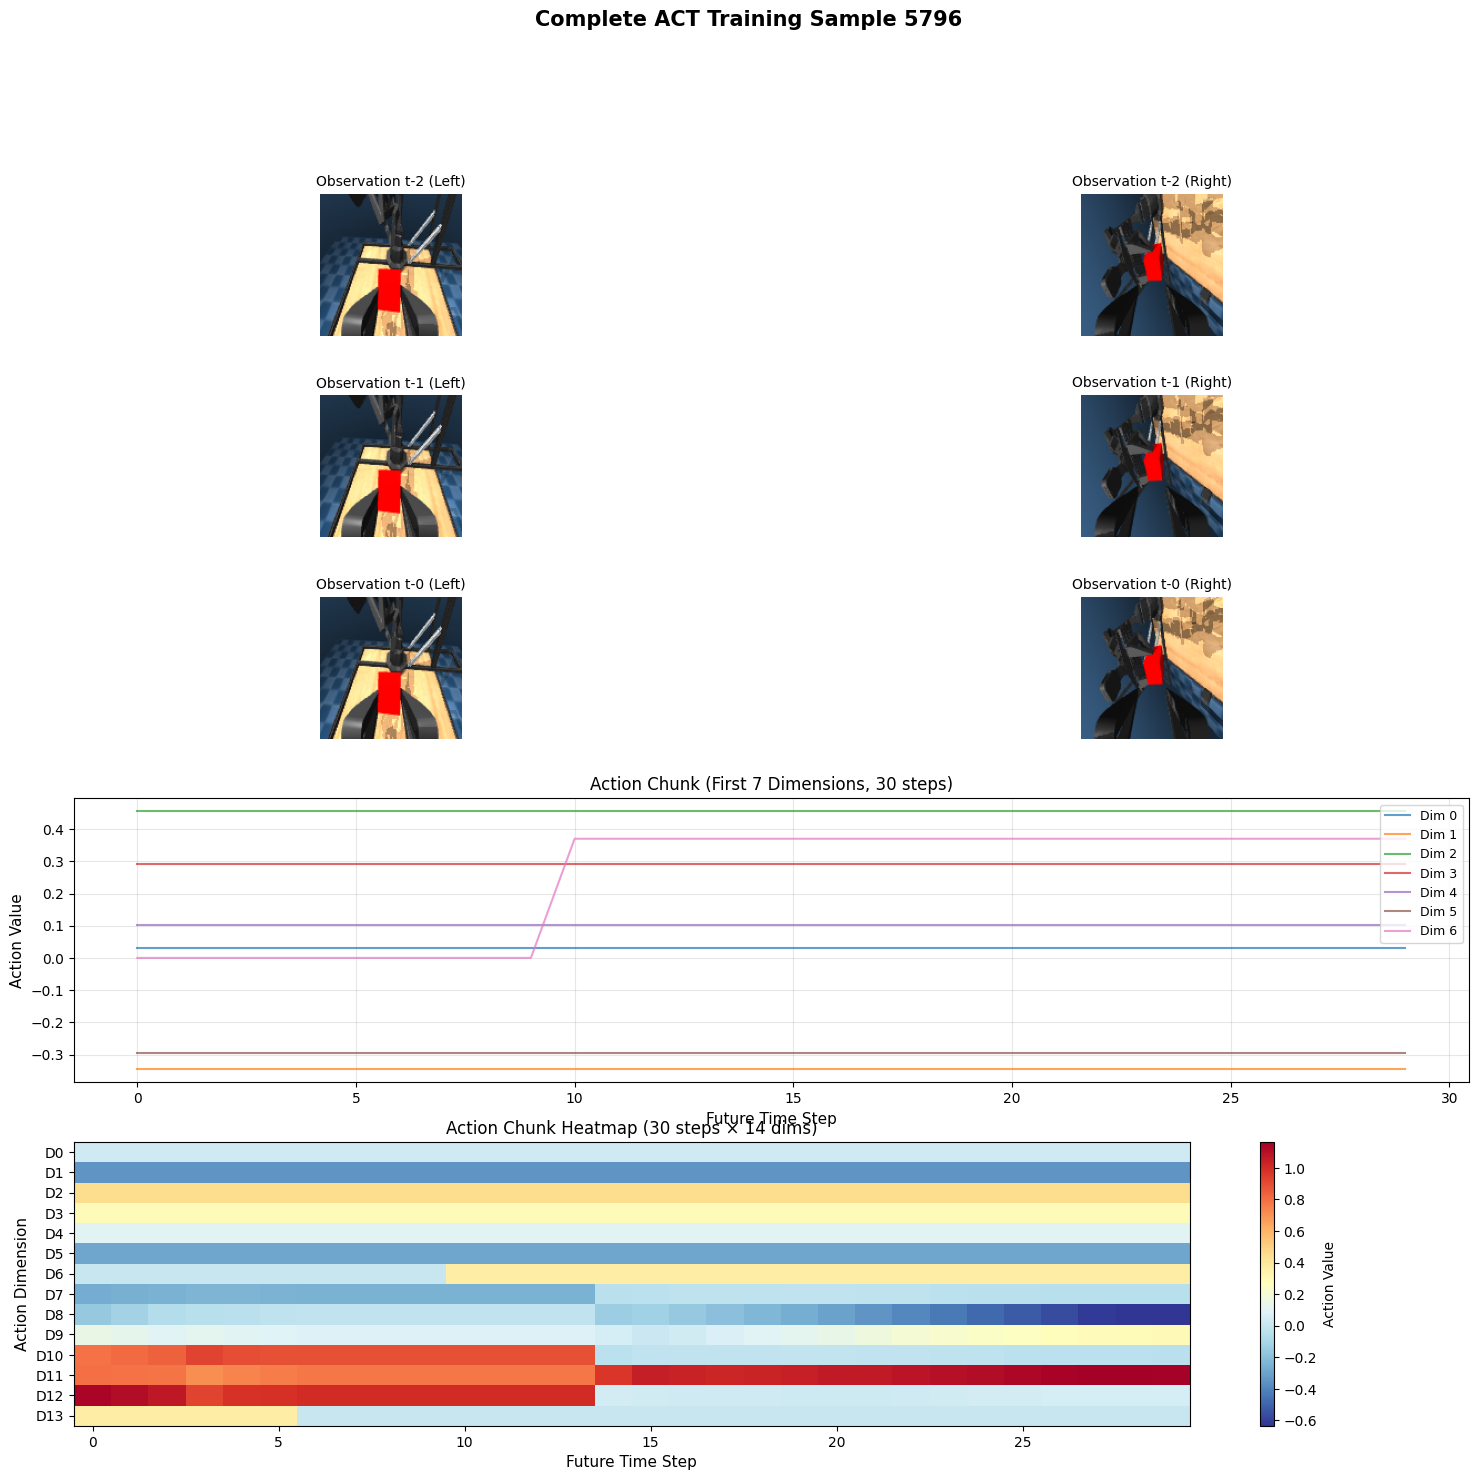


Sample 5796 Summary:
  Temporal context: 3 observations
  Action chunk: 30 future actions
  Action dimensions: 14
  Action range: [-0.634, 1.165]


In [ ]:
def visualize_act_sample(obs_sequence: TensorBimanualObs, action_chunk: TensorBimanualAction,
                          sample_idx: int = None):
    """
    Visualize a complete ACT training sample: temporal context + action chunk.

    Args:
        obs_sequence: Temporal sequence of observations
        action_chunk: Future action sequence
        sample_idx: Optional sample index
    """
    visual = obs_sequence.visual.cpu().numpy()
    action_array = action_chunk.array.cpu().numpy()
    temporal_context = visual.shape[0]
    chunk_size = action_array.shape[0]

    fig = plt.figure(figsize=(18, 4 * temporal_context + 4))
    gs = GridSpec(temporal_context + 2, 2, figure=fig, hspace=0.3, wspace=0.2,
                  height_ratios=[1]*temporal_context + [2, 2])

    title = f"Complete ACT Training Sample {sample_idx}" if sample_idx is not None else "Complete ACT Training Sample"
    fig.suptitle(title, fontsize=15, fontweight='bold', y=0.995)

    # Visualize temporal context (observations)
    for t in range(temporal_context):
        left_img = np.clip(visual[t, 0], 0, 1)
        right_img = np.clip(visual[t, 1], 0, 1)

        ax1 = fig.add_subplot(gs[t, 0])
        ax1.imshow(left_img)
        ax1.set_title(f"Observation t-{temporal_context-1-t} (Left)", fontsize=10)
        ax1.axis('off')

        ax2 = fig.add_subplot(gs[t, 1])
        ax2.imshow(right_img)
        ax2.set_title(f"Observation t-{temporal_context-1-t} (Right)", fontsize=10)
        ax2.axis('off')

    # Visualize action chunk (line plot)
    ax3 = fig.add_subplot(gs[temporal_context, :])
    for dim in range(min(7, action_array.shape[1])):  # Show first 7 dimensions
        ax3.plot(range(chunk_size), action_array[:, dim], alpha=0.7, label=f"Dim {dim}")
    ax3.set_xlabel("Future Time Step", fontsize=11)
    ax3.set_ylabel("Action Value", fontsize=11)
    ax3.set_title(f"Action Chunk (First 7 Dimensions, {chunk_size} steps)", fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper right', fontsize=9)

    # Visualize action chunk (heatmap)
    ax4 = fig.add_subplot(gs[temporal_context + 1, :])
    im = ax4.imshow(action_array.T, aspect='auto', cmap='RdYlBu_r', interpolation='nearest')
    ax4.set_xlabel("Future Time Step", fontsize=11)
    ax4.set_ylabel("Action Dimension", fontsize=11)
    ax4.set_title(f"Action Chunk Heatmap ({chunk_size} steps × 14 dims)", fontsize=12)
    ax4.set_yticks(range(action_array.shape[1]))
    ax4.set_yticklabels([f"D{i}" for i in range(action_array.shape[1])])
    plt.colorbar(im, ax=ax4, label="Action Value")

    plt.tight_layout()
    return fig

# Visualize a complete sample
sample_idx = temporal_indices[0]
obs_sequence, action_chunk = temporal_dataset[sample_idx]
fig = visualize_act_sample(obs_sequence, action_chunk, sample_idx=sample_idx)
plt.show()

print(f"\nSample {sample_idx} Summary:")
print(f"  Temporal context: {obs_sequence.visual.shape[0]} observations")
print(f"  Action chunk: {action_chunk.array.shape[0]} future actions")
print(f"  Action dimensions: {action_chunk.array.shape[1]}")
print(f"  Action range: [{action_chunk.array.min():.3f}, {action_chunk.array.max():.3f}]")


## 5. Dataset Statistics

Analyze the dataset to understand its distribution and characteristics.


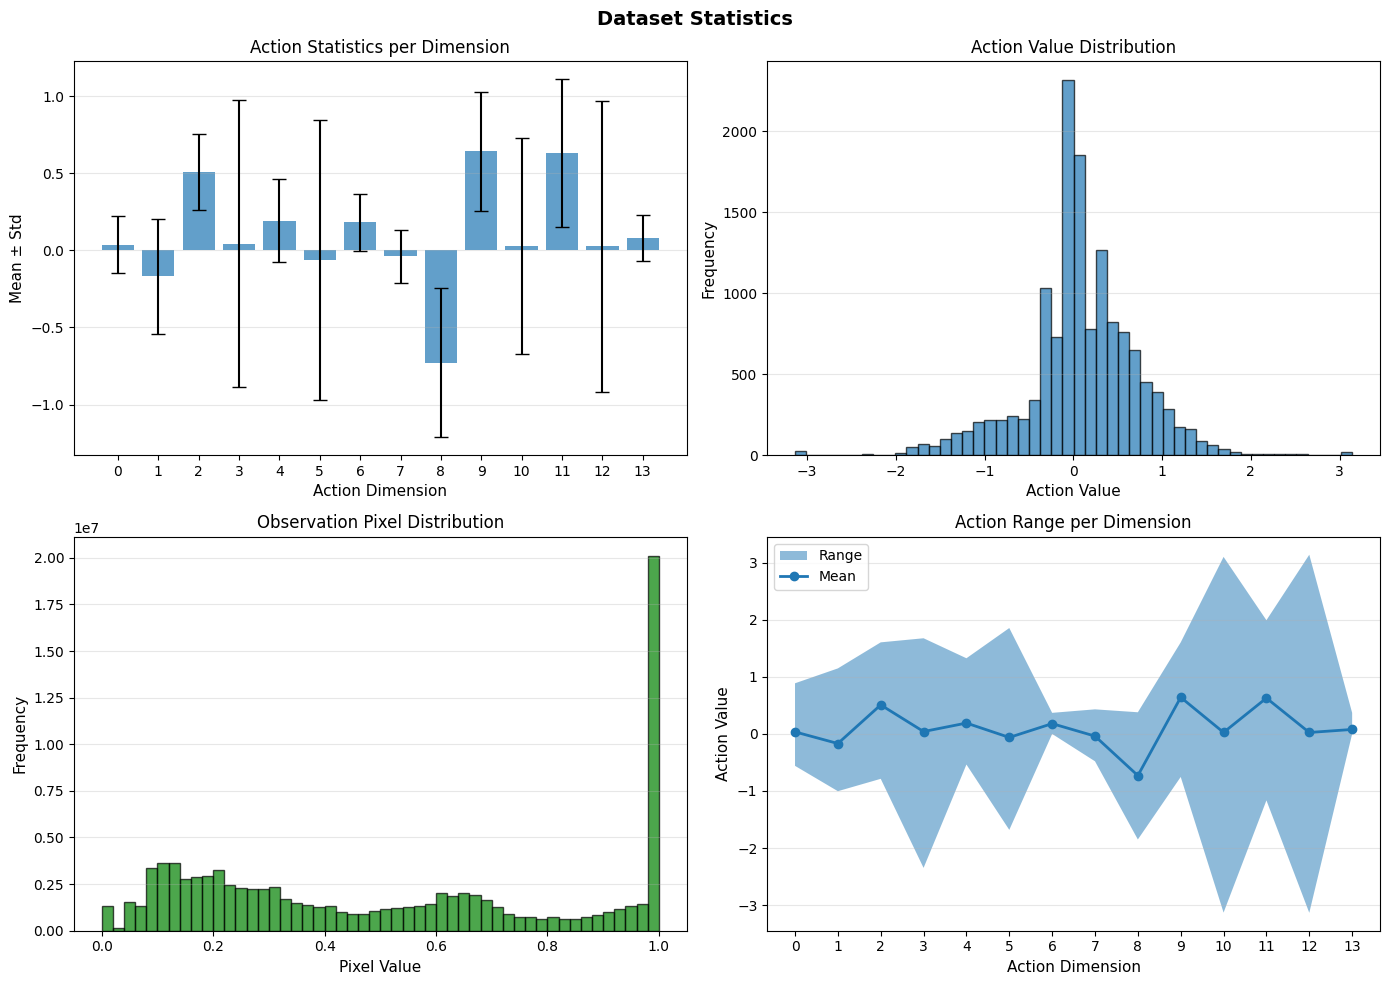


Dataset Statistics Summary
Total samples analyzed: 1000

Action Statistics:
  Mean: 0.0974
  Std:  0.6359
  Min:  -3.1357
  Max:  3.1416

Observation Statistics:
  Pixel mean: 0.5264
  Pixel std:  0.3400
  Pixel min:  0.0000
  Pixel max:  1.0000

Per-Action-Dimension Statistics:
  Dim  0: mean= 0.0361, std= 0.1847, range=[-0.5593,  0.8881]
  Dim  1: mean=-0.1678, std= 0.3731, range=[-1.0036,  1.1490]
  Dim  2: mean= 0.5092, std= 0.2463, range=[-0.7867,  1.6057]
  Dim  3: mean= 0.0418, std= 0.9307, range=[-2.3481,  1.6774]
  Dim  4: mean= 0.1909, std= 0.2684, range=[-0.5362,  1.3267]
  Dim  5: mean=-0.0611, std= 0.9088, range=[-1.6818,  1.8567]
  Dim  6: mean= 0.1809, std= 0.1850, range=[ 0.0000,  0.3700]
  Dim  7: mean=-0.0381, std= 0.1719, range=[-0.4795,  0.4313]
  Dim  8: mean=-0.7300, std= 0.4829, range=[-1.8500,  0.3801]
  Dim  9: mean= 0.6419, std= 0.3872, range=[-0.7539,  1.6051]
  Dim 10: mean= 0.0264, std= 0.7017, range=[-3.1319,  3.1035]
  Dim 11: mean= 0.6290, std= 0.4803, 

In [ ]:
# Collect statistics from a sample of the dataset
num_stats_samples = min(1000, len(base_dataset))
stats_indices = np.random.choice(len(base_dataset), num_stats_samples, replace=False)

actions_list = []
observations_list = []

print(f"Collecting statistics from {num_stats_samples} samples...")
for idx in stats_indices:
    obs, action = base_dataset[idx]
    actions_list.append(action.array[0].cpu().numpy())
    observations_list.append(obs.visual[0].cpu().numpy())

actions_array = np.array(actions_list)  # Shape: (num_samples, 14)
observations_array = np.array(observations_list)  # Shape: (num_samples, 2, H, W, 3)

# Plot action statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Dataset Statistics", fontsize=14, fontweight='bold')

# Action mean and std per dimension
ax1 = axes[0, 0]
action_mean = actions_array.mean(axis=0)
action_std = actions_array.std(axis=0)
x = np.arange(len(action_mean))
ax1.bar(x, action_mean, yerr=action_std, alpha=0.7, capsize=5)
ax1.set_xlabel("Action Dimension", fontsize=11)
ax1.set_ylabel("Mean ± Std", fontsize=11)
ax1.set_title("Action Statistics per Dimension", fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xticks(x)

# Action distribution (histogram of all values)
ax2 = axes[0, 1]
ax2.hist(actions_array.flatten(), bins=50, alpha=0.7, edgecolor='black')
ax2.set_xlabel("Action Value", fontsize=11)
ax2.set_ylabel("Frequency", fontsize=11)
ax2.set_title("Action Value Distribution", fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# Observation pixel statistics
ax3 = axes[1, 0]
obs_pixels = observations_array.flatten()
ax3.hist(obs_pixels, bins=50, alpha=0.7, edgecolor='black', color='green')
ax3.set_xlabel("Pixel Value", fontsize=11)
ax3.set_ylabel("Frequency", fontsize=11)
ax3.set_title("Observation Pixel Distribution", fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')

# Action range per dimension
ax4 = axes[1, 1]
action_min = actions_array.min(axis=0)
action_max = actions_array.max(axis=0)
x = np.arange(len(action_min))
ax4.fill_between(x, action_min, action_max, alpha=0.5, label='Range')
ax4.plot(x, action_mean, 'o-', label='Mean', linewidth=2)
ax4.set_xlabel("Action Dimension", fontsize=11)
ax4.set_ylabel("Action Value", fontsize=11)
ax4.set_title("Action Range per Dimension", fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_xticks(x)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print("Dataset Statistics Summary")
print(f"{'='*60}")
print(f"Total samples analyzed: {num_stats_samples}")
print(f"\nAction Statistics:")
print(f"  Mean: {actions_array.mean():.4f}")
print(f"  Std:  {actions_array.std():.4f}")
print(f"  Min:  {actions_array.min():.4f}")
print(f"  Max:  {actions_array.max():.4f}")
print(f"\nObservation Statistics:")
print(f"  Pixel mean: {obs_pixels.mean():.4f}")
print(f"  Pixel std:  {obs_pixels.std():.4f}")
print(f"  Pixel min:  {obs_pixels.min():.4f}")
print(f"  Pixel max:  {obs_pixels.max():.4f}")
print(f"\nPer-Action-Dimension Statistics:")
for dim in range(actions_array.shape[1]):
    print(f"  Dim {dim:2d}: mean={actions_array[:, dim].mean():7.4f}, "
          f"std={actions_array[:, dim].std():7.4f}, "
          f"range=[{actions_array[:, dim].min():7.4f}, {actions_array[:, dim].max():7.4f}]")


## 6. Verify Observation-Action Pairing

Verify that observations and actions are correctly paired by checking sequential samples.


In [ ]:
# Check sequential samples to verify pairing
print("Verifying observation-action pairing...")
print(f"\nChecking sequential samples from the same rollout:")

# Find a rollout with enough samples
for start, end in temporal_dataset.episode_boundaries[:3]:  # Check first 3 rollouts
    if end - start >= 5:
        print(f"\nRollout: indices {start} to {end-1} (length: {end-start})")

        # Visualize 3 consecutive samples
        for i in range(start, min(start + 3, end)):
            obs, action = base_dataset[i]

            # Show just the right camera for comparison
            visual = obs.visual[0].cpu().numpy()
            right_img = np.clip(visual[1], 0, 1)

            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].imshow(right_img)
            axes[0].set_title(f"Sample {i}: Right Camera", fontsize=11)
            axes[0].axis('off')

            # Show action
            action_array = action.array[0].cpu().numpy()
            axes[1].bar(range(len(action_array)), action_array, color='steelblue')
            axes[1].set_xlabel("Action Dim", fontsize=10)
            axes[1].set_ylabel("Value", fontsize=10)
            axes[1].set_title(f"Sample {i}: Action", fontsize=11)
            axes[1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            if i < end - 1:
                print(f"  Sample {i} → Sample {i+1}: Sequential pairing ✓")

        break  # Only check first valid rollout

print("\n✓ Pairing verification complete")


## Notes

- **Temporal Context**: The ACT policy uses `temporal_context` past observations to predict `chunk_size` future actions.
- **Observation Format**: Each observation contains 2 camera views (left and right wrist cameras) with shape `(H, W, 3)`.
- **Action Format**: Each action is a 14-dimensional vector (7 DOF per arm).
- **Episode Boundaries**: The temporal dataset correctly handles episode boundaries to prevent mixing data from different rollouts.

To use this notebook:
1. Update `DATASET_DIR` in cell 3 to point to your dataset
2. Adjust `TEMPORAL_CONTEXT` and `CHUNK_SIZE` to match your ACT config
3. Run all cells to visualize your training data
